In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import Audio
from peft import PeftModel
from sca_data.dataset_utils import easy_load
from speechbrain.inference.speaker import EncoderClassifier
from transformers import Qwen3OmniMoeProcessor, BitsAndBytesConfig

from sca_train.modeling import Qwen3OmniMoeWithProperForward, Qwen3OmniMoeWithProperForwardConfig

base_model_id = "huihui-ai/Huihui-Qwen3-Omni-30B-A3B-Instruct-abliterated"
adapter_path = "./SCA_finetune/final_consolidated"
dataset = easy_load()

speaker_encoder = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    run_opts={"device": "cuda" if torch.cuda.is_available() else "cpu"}
)

def get_speaker_embeds(audio_tensor_1d: torch.Tensor):
    if isinstance(audio_tensor_1d, np.ndarray):
        audio_tensor_1d = torch.from_numpy(audio_tensor_1d)
    return speaker_encoder.encode_batch(audio_tensor_1d.unsqueeze(0)).squeeze(1).cpu().to(torch.bfloat16)

hyperparams.yaml: 0.00B [00:00, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt: 0.00B [00:00, ?B/s]

In [2]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_storage=torch.bfloat16,
    # Skip quantization for these modules (kept in bf16)
    llm_int8_skip_modules=[
        "code_predictor",
        "mimi_model",
        "mimi_feature_extractor",
        "code2wav",
        "speaker_projection"
    ],
)

processor = Qwen3OmniMoeProcessor.from_pretrained(
    base_model_id,
    cache_dir="./.hf_models",
)

config = Qwen3OmniMoeWithProperForwardConfig.from_pretrained(
    base_model_id,
    cache_dir="./.hf_models",
    trust_remote_code=True,
)
config.torch_dtype = torch.bfloat16

model = Qwen3OmniMoeWithProperForward.from_pretrained(
    base_model_id,
    config=config,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    attn_implementation="flash_attention_2",
    cache_dir="./.hf_models",
)
model.load_mimi_model()
model = PeftModel.from_pretrained(model, adapter_path)
model = model.eval()

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
You are using a model of type qwen3_omni_moe to instantiate a model of type qwen3_omni_moe_with_proper_forward. This is not supported for all configurations of models and can yield errors.
Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'interleaved', 'mrope_section', 'mrope_interleaved'}
Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'interleaved', 'mrope_section'}
`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!
You 

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

Some weights of Qwen3OmniMoeWithProperForward were not initialized from the model checkpoint at huihui-ai/Huihui-Qwen3-Omni-30B-A3B-Instruct-abliterated and are newly initialized: ['speaker_projection.bias', 'speaker_projection.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading Mimi model from kyutai/mimi...
Mimi model loaded successfully!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen3OmniMoeWithProperForward(
      (thinker): Qwen3OmniMoeThinkerForConditionalGeneration(
        (audio_tower): Qwen3OmniMoeAudioEncoder(
          (positional_embedding): SinusoidsPositionEmbedding()
          (layers): ModuleList(
            (0-31): 32 x Qwen3OmniMoeAudioEncoderLayer(
              (self_attn): Qwen3OmniMoeAudioAttention(
                (k_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
                (v_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
                (q_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
                (out_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
              )
              (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
              (activation_fn): GELUActivation()
              (fc1): Linear4bit(in_features=1280, out_features=5120, bias=True)
           

In [4]:
entry = dataset[1245]
s_emb = get_speaker_embeds(entry['messages'][2]['content'][1]['audio_waveform'])
s_emb.shape

torch.Size([1, 192])

In [9]:
texts = processor.apply_chat_template([
    {
        "role": "system",
        "content": "You are a friendly assistant",
    },
    {
        "role": "user",
        "content": "Please introduce yourself to me.",
    },
], add_generation_prompt=True)

In [23]:
with torch.no_grad():
    processed = processor(
        text=texts,
        # audio=audios,
        # sampling_rate=16000,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=8192,
        use_audio_in_video=False,
    )
    processed = {k: v.to(model.device) if isinstance(v, torch.Tensor) else v
             for k, v in processed.items()}
    text_ids, audio = model.generate(
        **processed,
        # speaker_embedding=s_emb,
        speaker="Aiden",
        return_audio=True,
        thinker_return_dict_in_generate=True,
        use_audio_in_video=False,
    )
    result_text = processor.batch_decode(
        text_ids.sequences[:, processed["input_ids"].shape[1] :],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2150 for open-end generation.


In [24]:
result_text

["Hello! I am Qwen-Omni, a multimodal large-scale language model developed by Alibaba's Tongyi Lab. I am designed to understand and integrate information from multiple modalities, including text, images, audio, and video. I can process and respond to user inputs in real-time, supporting text, images, audio, and video inputs, as well as real-time microphone and camera recording. I am capable of answering questions, creating text such as stories, official documents, emails, and scripts, performing logical reasoning, coding, and more. I can also express opinions and play games. I support 100 languages, including Chinese, English, German, Spanish, French, Portuguese, Russian, Arabic, Japanese, Korean, Vietnamese, Thai, Indonesian, Persian, Hebrew, Malay, Turkish, and Dutch. I am committed to providing users with a seamless, intelligent, and natural interaction experience."]

In [25]:
display(Audio(data=entry['messages'][2]['content'][1]['audio_waveform'][24000*5:24000*10], rate=24000))
Audio(data=audio.reshape(-1).detach().cpu().numpy(), rate=24000)

In [26]:
import torchaudio

spec = torch.stft(audio.reshape(-1).detach().cpu(), n_fft=1024, return_complex=True)
stretched = torchaudio.transforms.TimeStretch(hop_length=512, n_freq=513)(spec, overriding_rate=0.8)
slowed = torch.istft(stretched, n_fft=1024, length=int(waveform.size(0)/0.8))

In [27]:
Audio(data=slowed, rate=24000)

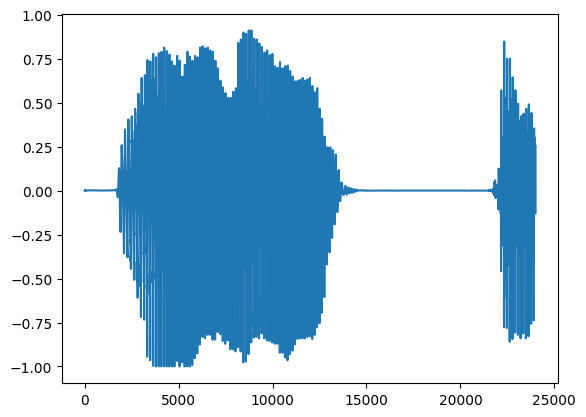

In [28]:
plt.plot(audio.reshape(-1).detach().cpu().numpy()[0:24000])